# Autoencoders for anomaly detection in Oxford Nanopore Technology direct RNA-Sequencing: identification of modified nucleotides.

**Author:** Adriano Fonzino, Ph.D. 

## 1.0. Introduction
Recently, many efforts have been sustained in order improve our ability to identify and map RNA modifications. These have been mainly focused on the use of next generation sequencing techniques. These platforms are, however, usually blind to nucleotides modification since they require a cDNA library preparation steps that masks base modifications. Furthermore, these are only indirect detection methods, without a univoque starndard and generic approach to retrieve the position and presence of RNA modifications at single base resolutions. Some protocols expect the use of specific antibotidies to recognize modifications or the use of chemical pretreatments (also in-vivo) with substances able to react specifically with modified bases. The incredible amount of RNA modifications (more than 150 at least) is not suitable to be harnessed easely only with this approaches since these are bound to the availability of both specific antibodies and chemical reagents. <br>

In this context Oxford Nanopore Technology (ONT) could play a pivotal role as game changer in the field of direct RNA sequencing and RNA/DNA modification detection. ONT is a company founded in 2005 as a spin-out from the University of Oxford. They produced a set of technologies used for single-molecule, long-read sequencing of DNA and RNA sequence. ONT sequencing is based on the use of a membrane with an array of nanopores, where the polynucleotide chain pass through generating a ionic current change since the voltage is "clamped" across the two side of the flowcell.

ONT is labelled, together with Pacific Biosciences (PacBio) instruments, as third-generation sequencing technologies and have been recently purposed as new tool for the dection of RNA modifications in native RNA sequences. It allowed, also thanks new protocols, the sequencing of direct-RNA single-molecules without the need of the intermediate cDNA library construction step. This ONT feature is very important and promising since it gives the possibility to preserve the nucleotide modifications as well.
In a nutshell, when modified nucleotides are present into the sequenced molecule, they cause a disruption of the ionic current across the pore that can be potentially identified by comparing raw current signals, known as "squiggle". Today, the main tool that tries to perform this inference is **Tombo**, a deep learning based algoritmh that requires a challeging step of re-squiggling and alignment of the current intensities and that it is "only" focused on m6A and m5C modifications at the moment.
Recently, in an article published on Nature Communications in the 2019 by Liu et al., researchers trained a Support Vector Machine (SVM) classifier that is able to predict modified m6A nucleotides into ONT native RNA-sequencing experiments basing on the "errors" that basecallers usually make when encounter base modifications. Thus, they understood and demonstrated that, basecallers "errors" can be interpretated as putative presence of a RNA modifications. They used an *in-vitro* transcribed 10kb-long artificial sequence to evaluate this aspect. The sequence, called here "curlcake" (from the software's name, used to produce it), contains all the possible combinations among the 4 nucleotides (A, C, G, U/T) in a kmer of length 5. They created two samples, one synthetized in presence of m6A-mofified nucleotides, and the other in absence of these as control, used to train the SVM model. Researchers called the model **EpiNano**. Results where confirmed by experiments using enginnered knock-out Yeasts not able to catalize m6A related reactions. The algoritmh were able to predict m6A modifications with a good degree of accuracy (about 90%). One of the limitations of EpiNano is the need of both control and modified samples to makes predictions.

This model can be obviously improved and put the basis of the experiment of this notebook. If both Tombo and EpiNano are able to predict RNA modifications basing on raw signals and basecallers errors, respectively, it means that probably, informations about the precence of modified nucleotides are embedded inside the raw signal of the ONT instrumentation. Tombo and EpiNano tries to make inferences with a supervised learning strategy using a binary classifiers (Deep Neural Network, DNN, and SVM) focusing on single type of modification at once. Here, I want to purpose a more general approach with respect the binary/multiclass classification strategy, that relies on either raw signals and basecaller errors, the latter intended in this case as anomalities of the currents, to predict someway which is the portion of the signal that is suspected to be related to bases modification. Indeed, a very interesting and powerful keypoint of the EpiNano strategy, is the choise to use synthetic constructs, with and without modifications, as training datasets. Thus in general, it could be that, everything outside the "normality" of unmodified 5mers produced signals, can potentially be correlated to modified nucleotides, in general. This is a problem that classically fall into the **Anomaly Detection** Field in signal interpretation.

Nowadays, the state of the art algoritmhs used for this purpose, are the **Autoencoders**, a group of generative unsupervised deep learning algoritmhs used for the reconstruction of high-dimensional input data. Summarizing, Autoencoders are DNN with narrow bottleneck layer at their center which contains the latent representation of the input data. The first part of the DNN that procude, starting from inputs, this latent representation is called **Encoder**, while the second part of the DNN is called **Decoder** because its aim is to reconstruct with the input data from the latent state minimizing the error between inputs and reconstructed output. 

<center> <img src='LSTM-Autoencoder-for-Anomaly-Detection.png' width="600" height="400"> </center>
<center> <i> AutoEncoder Structure. </i> </center> <br>

Autoencoders are used for several application, for instance Dimensionality Reduction, Reccomandation Engines, Images Denoising, Recongnition and Generation and also for Anomaly Detection. It there exist several types of autoencoders implementations with one common geneal architecture: an Encoder, a latent representation in the middel (the bottleneck) and the decoder. It is possible to use either a classic shallow feed-forward DNN, a Recurrent Neural Network (RNN), a Long Short Term-Memory (LTSM) DNN, etc. <br>
<br>

<center> <img src='RNN_image.jpg' width="500" height="131"> </center>
<center> <i> Recurrent Neural Network architecture. </i> </center> <br>

<br>
<br>
<br>
<br>

<center> <img src='LSTM_image.jpg' width="600" height="225"> </center>
<center> <i> Long-Short-Term-Memory Recurrent Neural Network architecture. </i> </center> <br>

The aim of this work is, in the end, to build an efficient Autoencoder trained on un-modified RNA raw signals data from ONT experiments able to detect anomalities in the modified (m6A) RNA raw signals using as dataset the EpiNano "curlcake" artifical constructs. See the "curlcake_dataset_exploration.ipynb" notebook for more information about the characteristics of the dataset.

<br>
<br>

<center> <img src='LSTM_AE_time_series.jpg' width="700" height="350"> </center>
<center> <i> LSTM-AE on timeserie data. </i> </center> <br>


## 1.1. Preliminar Steps

In [1]:
!pip install ont_fast5_api

     |████████████████████████████████| 2.0MB 23.6MB/s 
  Created wheel for progressbar33: filename=progressbar33-2.4-cp37-none-any.whl size=12151 sha256=7ed9ae6b7407eb8be714d14080727714ae7aa19d377657faa262e4af04a55741
  Stored in directory: /root/.cache/pip/wheels/3c/5a/22/73ae955a60c550ce36fae0f23cbb6d55bbf53123ee415f120c
Successfully built progressbar33


In [2]:
# assert usage of GPU
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
import os
from shutil import copyfile
# mounting gdrive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
colab_folder = "/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code"

In [5]:
# copying on working directory the ont_custom_function file to be used into this notebook.
ont_custom_function_folder = b"/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code/ont_custom_functions.py"
dest_folder = os.path.join(os.path.curdir, "ont_custom_functions.py")
copyfile(ont_custom_function_folder, dest_folder)

'./ont_custom_functions.py'

In [6]:
# importing basic modules
import os
from datetime import datetime
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from tqdm import tqdm
from ont_fast5_api.fast5_interface import get_fast5_file
from ont_custom_functions import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
import tensorflow as tf
import keras
from keras.layers import Input, Dropout, Dense, Bidirectional, LSTM, TimeDistributed, RepeatVector
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint

In [7]:
# set a random seed for reproducibility reason.
np.random.seed(1234)
tf.random.set_seed(1234)

## 2.0. Retrieve and Prepare the data

For sake of test, the first part of the computation will be performed on a subset of the data that fit in memory in order to evaluate the general behaviour of the network.
The autoencoders will be trained on a subset of the raw signal generated by the unmodified reads. A small part of this subset will be used to evaluate the performance on the unmodified data. Here the autoencoder shouldn't be able to find anomalities. After the test of the model on the unmodified reads, it will be challenged with a subset of raw signals of the m6A-related reads where the models should be able to detect anomalities. Then, the anomalities detected will be evaluated and analyzed to understand the abilities of the DNN to find, in a unsupervised manner, the modified nucleotides as anomalities. Data are stored as fast5 files (a dialect of the HDF5 file format) on the disk and have been previously mapped into a pandas DataFrame into the "curlcake_dataset_exploration.ipynb" of this project and saved as a .csv file.

We must exclude mux_scan reads, focusing on reads with fastq sequence stored into fast5 file and with at least 150k and not more than 300k measurements. This is because the network in this manner could have an higher probability to see the major part of the 5-mers composing the 4 curlcakes of the EpiNano dataset. We also focused on reads without too much high (or lower) currents values.

In [8]:
X_train_signals = pd.read_csv(os.path.join(colab_folder, "X_train_signals.csv"), index_col=0)
X_val_signals = pd.read_csv(os.path.join(colab_folder, "X_val_signals.csv"), index_col=0)
X_test_signals = pd.read_csv(os.path.join(colab_folder, "X_test_signals.csv"), index_col=0)
m6A_train_signals = pd.read_csv(os.path.join(colab_folder, "m6A_train_signals.csv"), index_col=0)
m6A_test_signals =pd.read_csv(os.path.join(colab_folder, "m6A_test_signals.csv"), index_col=0)

print("X_train_signal shape (measurements, reads)", X_train_signals.shape)
print("X_val_signal shape (measurements, reads)", X_val_signals.shape)
print("X_test_signal shape (measurements, reads)", X_test_signals.shape)
print("m6A_train_signal shape (measurements, reads)", m6A_train_signals.shape)
print("m6A_test_signal shape (measurements, reads)", m6A_test_signals.shape)

X_train_signal shape (measurements, reads) (295008, 400)
X_val_signal shape (measurements, reads) (298124, 400)
X_test_signal shape (measurements, reads) (265827, 200)
m6A_train_signal shape (measurements, reads) (292172, 399)
m6A_test_signal shape (measurements, reads) (284136, 201)


In [9]:
print("X_train_singnal memory usage:", int(X_train_signals.memory_usage().sum() /1024/1024), "Mb" )
print("X_val_singnal memory usage:", int(X_val_signals.memory_usage().sum() /1024/1024), "Mb" )
print("X_test_singnal memory usage:", int(X_test_signals.memory_usage().sum() /1024/1024), "Mb" )
print("m6A_train_singnal memory usage:", int(m6A_train_signals.memory_usage().sum() /1024/1024), "Mb" )
print("m6A_test_singnal memory usage:", int(m6A_test_signals.memory_usage().sum() /1024/1024), "Mb" )

X_train_singnal memory usage: 902 Mb
X_val_singnal memory usage: 912 Mb
X_test_singnal memory usage: 407 Mb
m6A_train_singnal memory usage: 891 Mb
m6A_test_singnal memory usage: 437 Mb


## 3.0. Autoencoder's Neural Network Model

In [10]:
# Training Parameters
TIME_STEPS = 10
n_features = 1
n_epochs = 25 # outer epochs.

# useful functions
def create_sequences(values, time_steps=TIME_STEPS):
    '''
    Function to create a time_step version of the sequence.
    '''
    output=[]
    for i in range(len(values)+1 - time_steps):
        output.append(values[i:(i+time_steps)])
    return np.stack(output).reshape(len(output), time_steps, 1)


def recostruct_sequence(timestep_sequence):
    '''
    Function to reconstruct the sequence starting
    from the time_step version.
    '''
    output = []
    output += list(timestep_sequence[0].ravel())
    for i in timestep_sequence[1:]:
        output.append( i.ravel()[-1] )
    #output += list(timestep_sequence[-1].ravel())
    output = np.array(output)
    return output


def get_mae(signal, model):
    '''
    Function to get the reconstruction MAE error from a raw signal after the transformation in time_steps
    version and prediction of the reconstructed signal.
    '''
    X_scaled = StandardScaler().fit_transform(signal.dropna().values.reshape(-1,1))
    time_steps = create_sequences(X_scaled)
    time_step_pred = model.predict(time_steps)
    mae_loss = np.mean(np.abs(time_step_pred - time_steps.reshape(time_steps.shape[0], time_steps.shape[1], 1)), axis=1)
    return mae_loss

In [11]:
# define model
model = Sequential()
# Encoder
model.add(Bidirectional(LSTM(15, return_sequences=True), input_shape=(TIME_STEPS, n_features), merge_mode="ave"))
model.add(Bidirectional(LSTM(5, return_sequences=False), merge_mode="ave"))
model.add(RepeatVector(TIME_STEPS))
# Decoder
model.add(Bidirectional(LSTM(5, return_sequences=True), merge_mode="ave"))
model.add(Bidirectional(LSTM(15, return_sequences=True), merge_mode="ave"))
model.add(TimeDistributed(Dense(n_features)))
# optimizer and loss function
model.compile(optimizer='rmsprop', loss='mse')
# print summary information
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 15)            2040      
_________________________________________________________________
bidirectional_1 (Bidirection (None, 5)                 840       
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 5)             0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 5)             440       
_________________________________________________________________
bidirectional_3 (Bidirection (None, 10, 15)            2520      
_________________________________________________________________
time_distributed (TimeDistri (None, 10, 1)             16        
Total params: 5,856
Trainable params: 5,856
Non-trainable params: 0
______________________________________________________

In [12]:
# a list with the history of each training for the current session and a list of the X_train sample already used
# for the network training. This could be a useful way to stop and continue the training.
histories = []
X_train_sample_used = []

In [84]:
# set version and date for the new model training
version = "3_0__"
date = str(datetime.today()).replace("-", "_").replace(" ", "_").split(".")[0].replace(":", "_")

# Prepare a directory to store all the checkpoints and history
checkpoint_dir = os.path.join(colab_folder, './ckpt_v'+ version + date)
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# define the checkpoint
filepath = os.path.join(checkpoint_dir, "model_v"+version+date+".h5")
filepath_history = os.path.join(checkpoint_dir, "model_v"+version+date+"_history.pickle")
filepath_X_train_sample_used = os.path.join(checkpoint_dir, "model_v"+version+date+"_Xtrain_used.pickle")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
# fit the model using the input also as target since this will be a reconstruction model.
from datetime import datetime
start_time = datetime.now()

# set the inner epoch to give the possibility to the optimizer to work well.
inner_epoch = 0 
# DA CAPIRE SE USARE FIT CON INTIAL_EPOCH/EPOCH O FIT_GENERATOR (SEMBRA DEPRECATO) O ANCORA TRAIN_ON_BATCH
# LEGGERE DOCUMENTAZIONE. CI POTREBBERO ESSERE PROBLEMI DI LEARNING RATE.
for epoch in range(1, n_epochs+1):
  print("\n#####################################################################################################")
  print("### Startinging Outer Epoch n°", epoch, "##############################################################\n")
  for i in X_train_signals.columns:
      # dropna() is for the presence of shorter sequences.
      # to avoid scale problems the signal of the reads have been standardized prior the training of the model.
      X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
      X_train_time_steps = create_sequences(X_scaled) 
      print("\nCurrent Outer Epoch n°", epoch, f"\nTraining on sample number {int(i)+1} of {len(X_train_signals.columns)}", X_train_time_steps.shape, "\n")
      print(inner_epoch)
      # fit the model with callbacks.
      history = model.fit(
          X_train_time_steps, X_train_time_steps,
          initial_epoch=inner_epoch,
          epochs=inner_epoch+1,
          batch_size=2048,
          validation_split=0.1,
          shuffle=False,
          callbacks=callbacks_list
      )
      inner_epoch += 1
      histories.append(history.history)
      X_train_sample_used.append(i)
      print("======================================================================================================================")
    
  print("\nSaving losses histories as serialized object on disk.")
  with open(filepath_history, "wb") as output_file:
    pickle.dump(histories, output_file)
  print("Saving used training samples histories as serialized object on disk.")
  with open(filepath_X_train_sample_used, "wb") as output_file:
    pickle.dump(X_train_sample_used, output_file)
  print("======================================================================================================================")

end_time = datetime.now()
elapsed_time = end_time - start_time
print("Elapsed time --> ", elapsed_time)

Output streaming troncato alle ultime 5000 righe.
Epoch 6530/6530
89/89 [==============================] - 2s 22ms/step - loss: 0.0211 - val_loss: 0.0223

Epoch 06530: loss did not improve from 0.00545

Current Outer Epoch n° 17 
Training on sample number 131 of 400 (164587, 10, 1) 

6530
Epoch 6531/6531
73/73 [==============================] - 2s 22ms/step - loss: 0.0213 - val_loss: 0.0231

Epoch 06531: loss did not improve from 0.00545

Current Outer Epoch n° 17 
Training on sample number 132 of 400 (160972, 10, 1) 

6531
Epoch 6532/6532
71/71 [==============================] - 2s 22ms/step - loss: 0.0226 - val_loss: 0.0265

Epoch 06532: loss did not improve from 0.00545

Current Outer Epoch n° 17 
Training on sample number 133 of 400 (171430, 10, 1) 

6532
Epoch 6533/6533
76/76 [==============================] - 2s 22ms/step - loss: 0.0219 - val_loss: 0.0299

Epoch 06533: loss did not improve from 0.00545

Current Outer Epoch n° 17 
Training on sample number 134 of 400 (195393, 10, 

In [26]:
# this cell can be used to load last best model and its histories without re-running the training of the model. Modify the paths to change
# the version of the trained model and its related lists you want to load.

checkpoint_dir = "/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code/ckpt_v3_0__2021_03_04_03_22_41"
filepath = "/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code/ckpt_v3_0__2021_03_04_03_22_41/model_v3_0__2021_03_04_03_22_41.h5"
filepath_history = "/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code/ckpt_v3_0__2021_03_04_03_22_41/model_v3_0__2021_03_04_03_22_41_history.pickle"
filepath_X_train_sample_used = "/content/drive/MyDrive/Master Data Science and Big Data Analytics Unipa 2020/7_Tirocinio - Tesi/PythonCode/colab_code/ckpt_v3_0__2021_03_04_03_22_41/model_v3_0__2021_03_04_03_22_41_Xtrain_used.pickle"

# load last best model
model = keras.models.load_model(filepath)


# load losses and used training samples histories to continue training from
# the subsequent sample.
with open(filepath_history, "rb") as input_file:
    histories = pickle.load(input_file)
with open(filepath_X_train_sample_used, "rb") as input_file:
    X_train_sample_used = pickle.load(input_file)


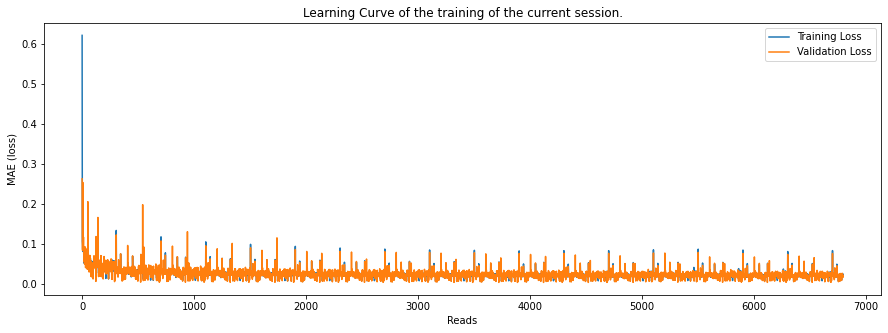

In [27]:
# plot the training and validation losses of all trainings in this session.
losses = []
val_losses = []

for training in histories:
    losses += training["loss"]
    val_losses += training["val_loss"]

# plotting
plt.figure(figsize=(15,5))
plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curve of the training of the current session.")
# plot as vline the epochs' ends
y_min = plt.axis()[2]
y_max = plt.axis()[3]
#for epoch in range(1, n_epochs+1):
#  plt.vlines(x=len(X_train_signals.columns) * epoch, ymin=y_min, ymax=y_max, colors="red", linestyles="dotted")
plt.xlabel("Reads")
plt.ylabel("MAE (loss)")
plt.legend()
plt.show()

In [ ]:
# load last best model
model = keras.models.load_model(filepath)

In [28]:
# to continue the training from the last X_train_sample_used, uncomment the following code and insert the right paths.

if X_train_sample_used != []:
  # define callbacks-checkpoint and callbacks_list objects
  checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
  callbacks_list = [checkpoint]

  # fit the model using the input also as target since this will be a reconstruction model.
  from datetime import datetime
  start_time = datetime.now()

  # set the inner epoch to give the possibility to the optimizer to work well.
  inner_epoch = 7028 
  # DA CAPIRE SE USARE FIT CON INTIAL_EPOCH/EPOCH O FIT_GENERATOR (SEMBRA DEPRECATO) O ANCORA TRAIN_ON_BATCH
  # LEGGERE DOCUMENTAZIONE. CI POTREBBERO ESSERE PROBLEMI DI LEARNING RATE.
  for epoch in range(18, n_epochs+1):
    print("\n#####################################################################################################")
    print("### Startinging Outer Epoch n°", epoch, "##############################################################\n")
    for i in X_train_signals.columns:
        # dropna() is for the presence of shorter sequences.
        # to avoid scale problems the signal of the reads have been standardized prior the training of the model.
        X_scaled = StandardScaler().fit_transform(X_train_signals[i].dropna().values.reshape(-1,1)) 
        X_train_time_steps = create_sequences(X_scaled) 
        print("\nCurrent Outer Epoch n°", epoch, f"\nTraining on sample number {int(i)+1} of {len(X_train_signals.columns)}", X_train_time_steps.shape, "\n")
        print(inner_epoch)
        # fit the model with callbacks.
        history = model.fit(
            X_train_time_steps, X_train_time_steps,
            initial_epoch=inner_epoch,
            epochs=inner_epoch+1,
            batch_size=2048,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks_list
        )
        inner_epoch += 1
        histories.append(history.history)
        X_train_sample_used.append(i)
        print("======================================================================================================================")
      
    print("\nSaving losses histories as serialized object on disk.")
    with open(filepath_history, "wb") as output_file:
      pickle.dump(histories, output_file)
    print("Saving used training samples histories as serialized object on disk.")
    with open(filepath_X_train_sample_used, "wb") as output_file:
      pickle.dump(X_train_sample_used, output_file)
    print("======================================================================================================================")

  end_time = datetime.now()
  elapsed_time = end_time - start_time
  print("Elapsed time --> ", elapsed_time)

Output streaming troncato alle ultime 5000 righe.

9729
Epoch 9730/9730
67/67 [==============================] - 1s 20ms/step - loss: 0.0238 - val_loss: 0.0184

Epoch 09730: loss did not improve from 0.00552

Current Outer Epoch n° 24 
Training on sample number 303 of 400 (152313, 10, 1) 

9730
Epoch 9731/9731
67/67 [==============================] - 1s 20ms/step - loss: 0.0221 - val_loss: 0.0228

Epoch 09731: loss did not improve from 0.00552

Current Outer Epoch n° 24 
Training on sample number 304 of 400 (154016, 10, 1) 

9731
Epoch 9732/9732
68/68 [==============================] - 1s 20ms/step - loss: 0.0206 - val_loss: 0.0209

Epoch 09732: loss did not improve from 0.00552

Current Outer Epoch n° 24 
Training on sample number 305 of 400 (154881, 10, 1) 

9732
Epoch 9733/9733
69/69 [==============================] - 1s 20ms/step - loss: 0.0224 - val_loss: 0.0245

Epoch 09733: loss did not improve from 0.00552

Current Outer Epoch n° 24 
Training on sample number 306 of 400 (192434

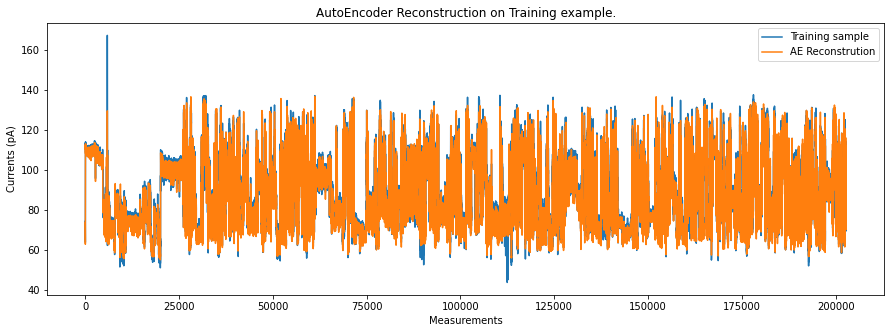

In [29]:
# Visualize reconstructed signal of on a training sample 
sc = StandardScaler()
train_sample = X_train_signals[str(0)].dropna().values.reshape(-1,1)
train_sample_sc = sc.fit_transform(train_sample)
train_sample_time_step = create_sequences(train_sample_sc)
train_sample_pred = model.predict(create_sequences(train_sample_sc))
reconstructed_signal = recostruct_sequence(train_sample_pred)
reconstructed_signal = sc.inverse_transform(reconstructed_signal)

# plot results
plt.figure(figsize=(15,5))
plt.plot(train_sample, label="Training sample")
plt.plot(reconstructed_signal, label="AE Reconstrution")
plt.title("AutoEncoder Reconstruction on Training example.")
plt.xlabel("Measurements")
plt.ylabel("Currents (pA)")
plt.legend()
plt.show()

In [31]:
# Getting all the threshold computed for the training samples by the model
thresholds = []
mae_losses = []
with tqdm(total=len(X_train_signals.columns[0:10])) as pbar:
    for i in X_train_signals.columns[0:10]:
        train_mae_loss = get_mae(X_train_signals[i], model)
        mae_losses.append(train_mae_loss)

        # Get reconstruction loss thresholds.
        threshold = np.max(train_mae_loss)
        thresholds.append(threshold)
        pbar.update(1)

# save as serialized item the threshold list
with open(os.path.join(checkpoint_dir, "train_thresholds.pickle"), "wb") as output_file:
          pickle.dump(thresholds, output_file)
# save as serialized item the mae_losses list
with open(os.path.join(checkpoint_dir, "train_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(mae_losses, output_file)

100%|██████████| 10/10 [04:36<00:00, 27.62s/it]


In [32]:
# use this cell to load from serialized object on disk both mae_losses and thresholds list for the training dataset without computing them another time.
'''
with open(os.path.join(checkpoint_dir, "train_thresholds.pickle"), "rb") as input_file: # thresholds list loading
    thresholds = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "train_mae_losses.pickle"), "rb") as input_file: # mae_losses loading
    mae_losses = pickle.load(input_file)
'''

'\nwith open(os.path.join(checkpoint_dir, "train_thresholds.pickle"), "rb") as input_file: # thresholds list loading\n    thresholds = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "train_mae_losses.pickle"), "rb") as input_file: # mae_losses loading\n    mae_losses = pickle.load(input_file)\n'

In [33]:
threshold_max = round(np.max(thresholds), 2)
print("Mean Threshold +/- S.D. on Training samples:", round(np.mean(thresholds), 2), "+/-", round(np.std(thresholds), 2), "S.D.")
print("Max Value for Threshold in training samples:", threshold_max)

Mean Threshold +/- S.D. on Training samples: 1.03 +/- 0.14 S.D.
Max Value for Threshold in training samples: 1.4


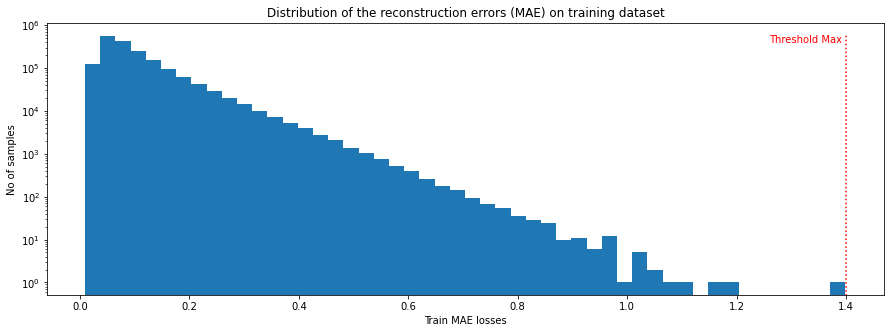

Reconstruction error threshold:  1.4


In [34]:
# plotting MAE reconstruction errors of the training dataset to visualize the maximum threshold.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on training dataset")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Train MAE losses")
plt.ylabel("No of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Reconstruction error threshold: ", threshold_max)

## 3.1. Evaluation of the model on X_val dataset.

Now I'd like to see if this threshold works well also on another unmodified read not yet used for the training of the model from the X_val dataframe. Thus we have to use the X_val_signal dataset with the raw signals converted to pA of the unmodified reads, in order to start the evaluations.

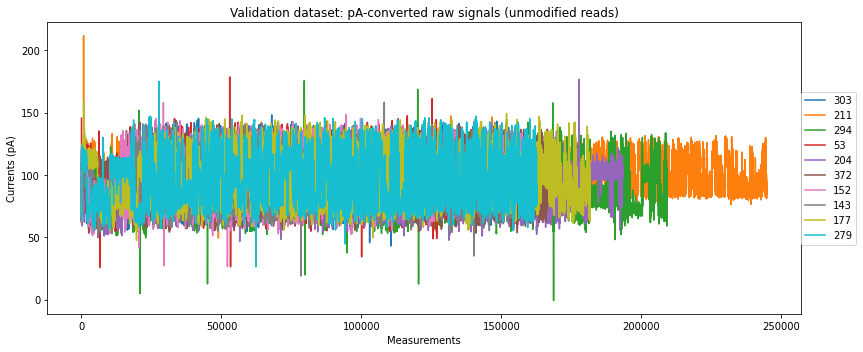

In [35]:
random_indices = np.random.choice(X_val_signals.columns, 10)
X_val_signals[random_indices].plot(figsize=(12,5))
plt.title("Validation dataset: pA-converted raw signals (unmodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [36]:
# Getting all the MAE reconstruction errors computed for the validation samples by the model
from tqdm import tqdm

val_mae_losses = [] # where are stored the mae losses of validation samples.
val_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
val_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_val_signals.columns[0:10])) as pbar:
    for i in X_val_signals.columns[0:10]:
        val_mae_loss = get_mae(X_val_signals[i], model)
        val_mae_losses.append(val_mae_loss)
        anomalies = val_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        val_sum_anomalies.append(sum_anomalies)
        val_anomaly_indices.append(anomalies_indices)
  
        pbar.update(1)

# save as serialized item the val_mae_losses list
with open(os.path.join(checkpoint_dir, "val_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(val_mae_losses, output_file)
# save as serialized item the val_sum_anomalies list
with open(os.path.join(checkpoint_dir, "val_sum_anomalies.pickle"), "wb") as output_file:
          pickle.dump(val_sum_anomalies, output_file)
# save as serialized item the val_anomaly_indices list
with open(os.path.join(checkpoint_dir, "train_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(val_anomaly_indices, output_file)

100%|██████████| 10/10 [05:02<00:00, 30.29s/it]


In [37]:
# use this cell to load from serialized object on disk either val_mae_losses, val_sum_anomalies and val_anomaly_indices lists for 
# the validation dataset without computing them another time.
'''
with open(os.path.join(checkpoint_dir, "val_mae_losses.pickle"), "rb") as input_file: # val_mae_losses list loading
    thresholds = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "val_sum_anomalies.pickle"), "rb") as input_file: # val_sum_anomalies loading
    mae_losses = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "val_anomaly_indices.pickle"), "rb") as input_file: # val_anomaly_indices loading
    mae_losses = pickle.load(input_file)
'''

'\nwith open(os.path.join(checkpoint_dir, "val_mae_losses.pickle"), "rb") as input_file: # val_mae_losses list loading\n    thresholds = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "val_sum_anomalies.pickle"), "rb") as input_file: # val_sum_anomalies loading\n    mae_losses = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "val_anomaly_indices.pickle"), "rb") as input_file: # val_anomaly_indices loading\n    mae_losses = pickle.load(input_file)\n'

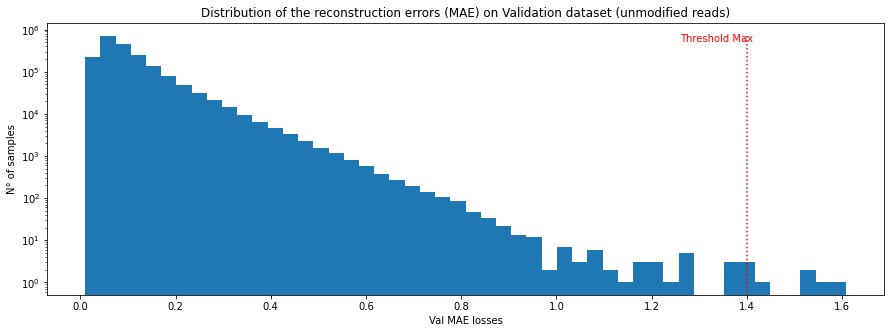

Number of anomaly samples in validation reads: 7


In [38]:
# plotting MAE reconstruction errors of the validation dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(val_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Validation dataset (unmodified reads)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Val MAE losses")
plt.ylabel("N° of samples")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.show()

print("Number of anomaly samples in validation reads:", np.sum(val_sum_anomalies))

Few anomalities have been found in the umodified validation dataset of reads. The model seems to be able to discriminate using this threshold computed from training dataset. <br> <br>
<br>
## 3.2. Evaluation of the model on m6A modified dataset
First of all we need to split m6A subset data into training and test sets. Then I'm going to retrieve the pA-reconstructed raw signals for the m6A reads from the corresponding fast5 file. 

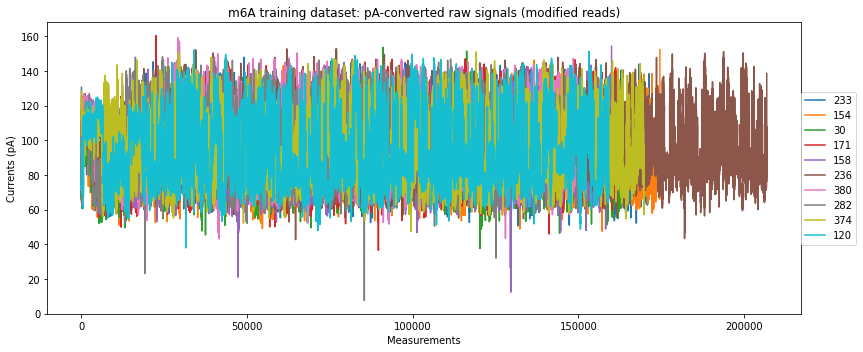

In [39]:
random_indices = np.random.choice(m6A_train_signals.columns, 10)
m6A_train_signals[random_indices].plot(figsize=(12,5))
plt.title("m6A training dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [40]:
# Getting all the MAE reconstruction errors computed for the m6A training samples by the model
from tqdm import tqdm

m6A_train_mae_losses = [] # where are stored the mae losses of m6A training samples.
m6A_train_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_train_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_train_signals.columns[0:10])) as pbar:
    for i in m6A_train_signals.columns[0:10]:
        m6A_train_mae_loss = get_mae(m6A_train_signals[i], model)
        m6A_train_mae_losses.append(m6A_train_mae_loss)
        anomalies = m6A_train_mae_loss > threshold_max
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_train_sum_anomalies.append(sum_anomalies)
        m6A_train_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

# save as serialized item the m6A_train_mae_losses list
with open(os.path.join(checkpoint_dir, "m6A_train_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(m6A_train_mae_losses, output_file)
# save as serialized item the m6A_train_sum_anomalies list
with open(os.path.join(checkpoint_dir, "m6A_train_sum_anomalies.pickle"), "wb") as output_file:
          pickle.dump(m6A_train_sum_anomalies, output_file)
# save as serialized item the m6A_train_anomaly_indices list
with open(os.path.join(checkpoint_dir, "m6A_train_anomaly_indices.pickle"), "wb") as output_file:
          pickle.dump(m6A_train_anomaly_indices, output_file)

100%|██████████| 10/10 [04:22<00:00, 26.30s/it]


In [41]:
# use this cell to load from serialized object on disk either m6A_train_mae_losses, m6A_train_sum_anomalies and m6A_train_anomaly_indices lists for 
# the m6A_train / validation dataset without computing them another time.
'''
with open(os.path.join(checkpoint_dir, "m6A_train_mae_losses.pickle"), "rb") as input_file: # m6A_train_mae_losses list loading
    thresholds = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "m6A_train_sum_anomalies.pickle"), "rb") as input_file: # m6A_train_sum_anomalies loading
    mae_losses = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "m6A_train_anomaly_indices.pickle"), "rb") as input_file: # m6A_train_anomaly_indices loading
    mae_losses = pickle.load(input_file)
'''

'\nwith open(os.path.join(checkpoint_dir, "m6A_train_mae_losses.pickle"), "rb") as input_file: # m6A_train_mae_losses list loading\n    thresholds = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "m6A_train_sum_anomalies.pickle"), "rb") as input_file: # m6A_train_sum_anomalies loading\n    mae_losses = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "m6A_train_anomaly_indices.pickle"), "rb") as input_file: # m6A_train_anomaly_indices loading\n    mae_losses = pickle.load(input_file)\n'

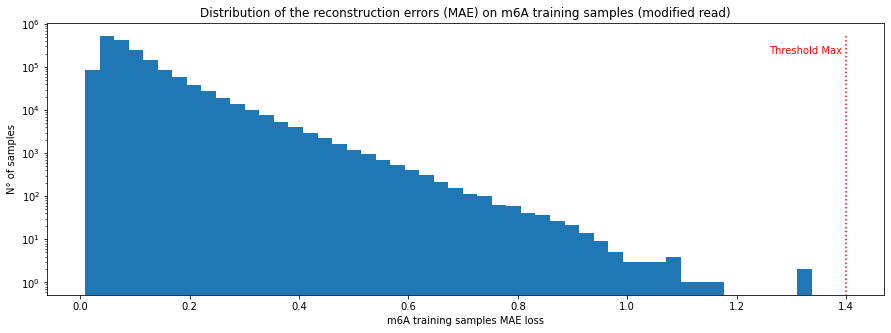

Number of anomaly samples: 0


In [42]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_train_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A training samples (modified read)")
plt.vlines(threshold_max, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(threshold_max*0.9, plt.axis()[3]*0.35, "Threshold Max", c="r")
plt.yscale(value="log")
plt.xlabel("m6A training samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

print("Number of anomaly samples:", np.sum(m6A_train_sum_anomalies))

## 3.3. Choose the Best Threshold on Validation sets.

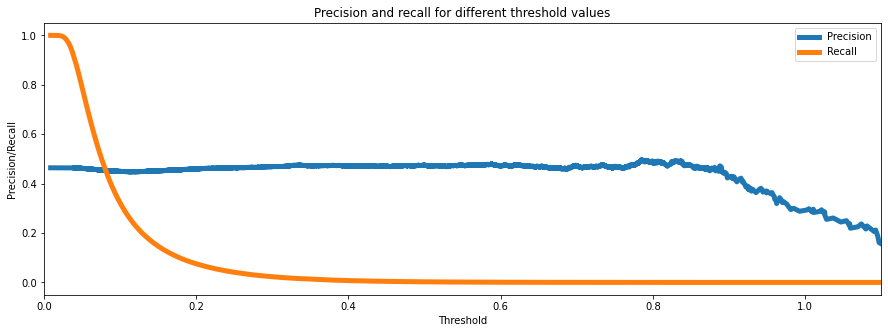

In [43]:
y_m6A_train = np.array([1 for i in np.concatenate(m6A_train_mae_losses)]) # real class vector for m6A_train losses
y_unmod_val = np.array([0 for i in np.concatenate(val_mae_losses)]) # real class vector for X_val unmodifed reads losses
# concatenate both of them into single vector
mse_total_val = np.concatenate([np.concatenate(m6A_train_mae_losses), np.concatenate(val_mae_losses)])
# concatenate also class labels into a single vector
y_total_val = np.concatenate([y_m6A_train, y_unmod_val])

# calculating precision/reacall scores over the threshold values
precision_rt, recall_rt, threshold_rt = precision_recall_curve(y_total_val, mse_total_val)

# producing precision/recall vs threshold curves
plt.figure(figsize=(15,5))
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim(0, 1.1)
plt.legend()
plt.show()

Obviously, since the classes have been assigned in a not-common manner, with m6A modified reads containing either normal events and bases, the Precision/Recall vs threshold curves are not easily interpretable. Anyway they give some information about the behaviour of the model. It's better to use these information together with another way to see the problem that is the number of anomalies found in unmodified and m6A-modified reads by the variation of the threshold value on the validations sets as following:

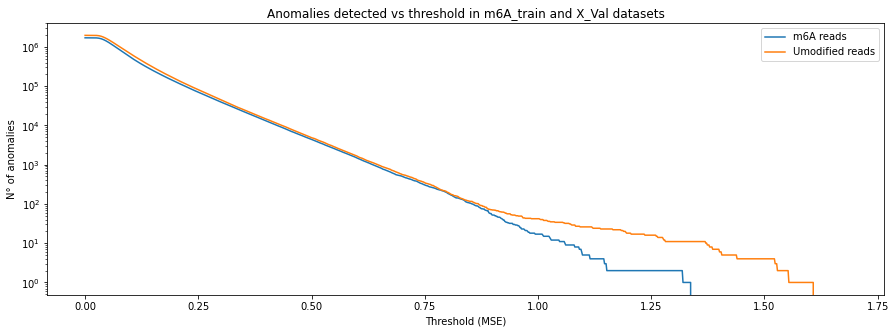

In [44]:
# evaluate how the number of detected anomalies changes in both 
# m6A_train and unmodified X_val samples in function of the threshold value.
trs = []
m6A_over_t = []
unmod_over_t =[]
for t in np.linspace(0, threshold_max*1.20, 1000):
    trs.append(t)
    m6A_over_t.append(np.sum(np.concatenate(m6A_train_mae_losses) > t))
    unmod_over_t.append(np.sum(np.concatenate(val_mae_losses) > t))

plt.figure(figsize=(15,5))
plt.plot(trs, m6A_over_t, label="m6A reads")
plt.plot(trs, unmod_over_t, label="Umodified reads")
plt.xlabel("Threshold (MSE)")
plt.ylabel("N° of anomalies")
plt.yscale("log")
plt.title("Anomalies detected vs threshold in m6A_train and X_Val datasets")
plt.legend()
plt.show()

In [45]:
# Detecting a good threshold as the minimum threshold value with 0 anomalies in unmodified reads
min_value_umod_anom = np.min(np.array(unmod_over_t))
min_index_unmod = np.min(np.argwhere(np.array(unmod_over_t) == min_value_umod_anom)) # first index where no anomalies are detected in unmodified data
new_threshold = trs[min_index_unmod] # threshold with 0 anomalies in unmodified reads
print("Best Threshold is:", new_threshold)

Best Threshold is: 1.6093693693693694


A good threshold seems to be: 1.6093693693693694 MAE

Number of anomalies in m6A_train samples: 0
Percentage of anomalies in modified m6A_train dataset on total measurements evaluated: 0.0 %

Number of anomalies in X_val samples: 0
Percentage of anomalies in unmodified X_val dataset on total measurements evaluated: 0.0 %

m6A_train/X_val anomalies ratio nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


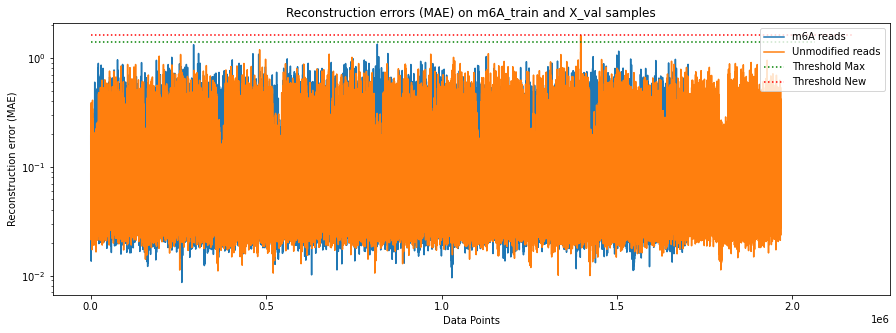

In [46]:
# Visualize results on Validation sets with the new best threshold and the old one computed on the training dataset.
print(f"A good threshold seems to be: {new_threshold} MAE\n")
# Results on m6A_train and X_val datasets:
print("Number of anomalies in m6A_train samples:", np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold))
print("Percentage of anomalies in modified m6A_train dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / np.concatenate(m6A_train_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_val samples:", np.sum(np.concatenate(val_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_val dataset on total measurements evaluated:", round(np.sum(np.concatenate(val_mae_losses) > new_threshold) / np.concatenate(val_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_train/X_val anomalies ratio", 
        np.sum(np.concatenate(m6A_train_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(val_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_train and X_val samples")
plt.plot(np.concatenate(m6A_train_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(val_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold Max", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold New", zorder=4)
plt.legend()
plt.show()

## 4.0. Evaluation on test sets

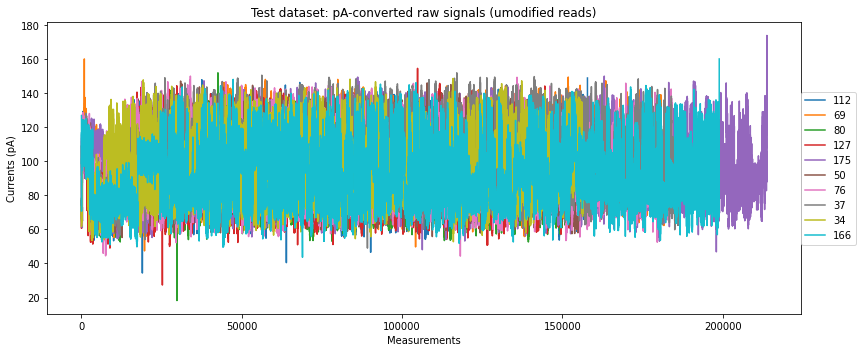

In [47]:
random_indices = np.random.choice(X_test_signals.columns, 10)
X_test_signals[random_indices].plot(figsize=(12,5))
plt.title("Test dataset: pA-converted raw signals (umodified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [48]:
# Getting all the MAE reconstruction errors computed for the test samples by the model
from tqdm import tqdm

test_mae_losses = [] # where are stored the mae losses of test samples.
test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(X_test_signals.columns[0:10])) as pbar:
    for i in X_test_signals.columns[0:10]:
        test_mae_loss = get_mae(X_test_signals[i], model)
        test_mae_losses.append(test_mae_loss)
        anomalies = test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        test_sum_anomalies.append(sum_anomalies)
        test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

# save as serialized item the test_mae_losses list
with open(os.path.join(checkpoint_dir, "test_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(test_mae_losses, output_file)
# save as serialized item the test_sum_anomalies list
with open(os.path.join(checkpoint_dir, "test_sum_anomalies.pickle"), "wb") as output_file:
          pickle.dump(test_sum_anomalies, output_file)
# save as serialized item the test_anomaly_indices list
with open(os.path.join(checkpoint_dir, "test_anomaly_indices.pickle"), "wb") as output_file:
          pickle.dump(test_anomaly_indices, output_file)

100%|██████████| 10/10 [04:20<00:00, 26.02s/it]


In [49]:
# use this cell to load from serialized object on disk either test_mae_losses, test_sum_anomalies and test_anomaly_indices lists for 
# the X_test dataset without computing them another time.
'''
with open(os.path.join(checkpoint_dir, "test_mae_losses.pickle"), "rb") as input_file: # test_mae_losses list loading
    thresholds = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "test_sum_anomalies.pickle"), "rb") as input_file: # test_sum_anomalies loading
    mae_losses = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "test_anomaly_indices.pickle"), "rb") as input_file: # test_anomaly_indices loading
    mae_losses = pickle.load(input_file)
'''

'\nwith open(os.path.join(checkpoint_dir, "test_mae_losses.pickle"), "rb") as input_file: # test_mae_losses list loading\n    thresholds = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "test_sum_anomalies.pickle"), "rb") as input_file: # test_sum_anomalies loading\n    mae_losses = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "test_anomaly_indices.pickle"), "rb") as input_file: # test_anomaly_indices loading\n    mae_losses = pickle.load(input_file)\n'

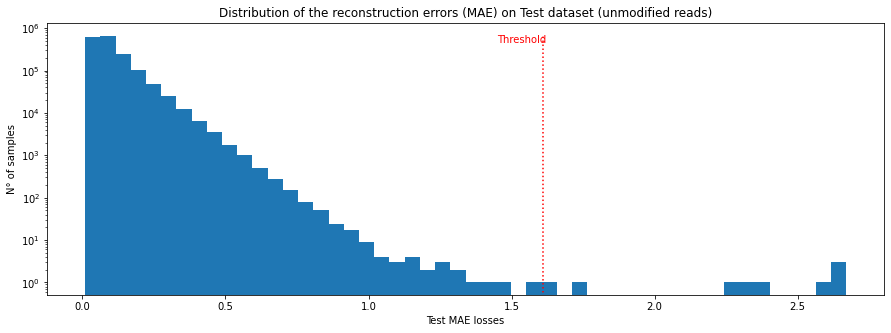

Number of anomaly samples in test reads: 9


In [50]:
# plotting MAE reconstruction errors of the test dataset.
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on Test dataset (unmodified reads)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.yscale(value="log")
plt.xlabel("Test MAE losses")
plt.ylabel("N° of samples")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.show()
print("Number of anomaly samples in test reads:", np.sum(test_sum_anomalies))

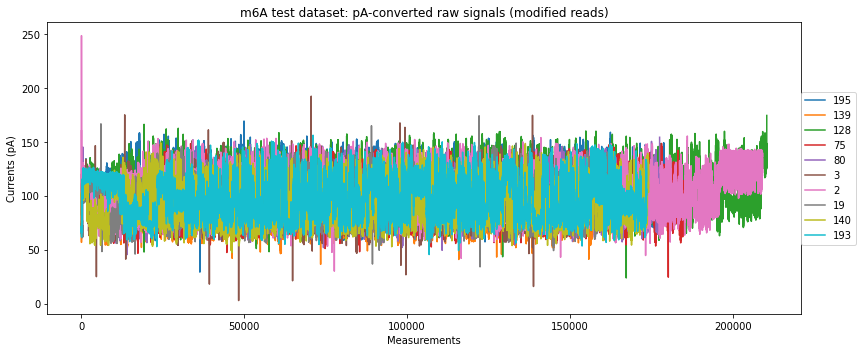

In [51]:
random_indices = np.random.choice(m6A_test_signals.columns, 10)
m6A_test_signals[random_indices].plot(figsize=(12,5))
plt.title("m6A test dataset: pA-converted raw signals (modified reads)")
plt.ylabel("Currents (pA)")
plt.xlabel("Measurements")
plt.legend(bbox_to_anchor=(1.08, 0.5), loc="right")
plt.tight_layout()
plt.show()

In [52]:
# Getting all the MAE reconstruction errors computed for the m6A test samples by the model
from tqdm import tqdm

m6A_test_mae_losses = [] # where are stored the mae losses of m6A test samples.
m6A_test_sum_anomalies = [] # where are stored the cumulative number of anomalies per sample.
m6A_test_anomaly_indices = [] # where are stored the indices of the anomalies with respect the time_step version of the samples
with tqdm(total=len(m6A_test_signals.columns[0:10])) as pbar:
    for i in m6A_test_signals.columns[0:10]:
        m6A_test_mae_loss = get_mae(m6A_test_signals[i], model)
        m6A_test_mae_losses.append(m6A_test_mae_loss)
        anomalies = m6A_test_mae_loss > new_threshold
        sum_anomalies = np.sum(anomalies)
        anomalies_indices = np.where(anomalies)
        m6A_test_sum_anomalies.append(sum_anomalies)
        m6A_test_anomaly_indices.append(anomalies_indices)

        pbar.update(1)

# save as serialized item the m6A_test_mae_losses list
with open(os.path.join(checkpoint_dir, "m6A_test_mae_losses.pickle"), "wb") as output_file:
          pickle.dump(m6A_test_mae_losses, output_file)
# save as serialized item the m6A_test_sum_anomalies list
with open(os.path.join(checkpoint_dir, "m6A_test_sum_anomalies.pickle"), "wb") as output_file:
          pickle.dump(m6A_test_sum_anomalies, output_file)
# save as serialized item the m6A_test_anomaly_indices list
with open(os.path.join(checkpoint_dir, "m6A_test_anomaly_indices.pickle"), "wb") as output_file:
          pickle.dump(m6A_test_anomaly_indices, output_file)

100%|██████████| 10/10 [04:49<00:00, 28.93s/it]


In [53]:
# use this cell to load from serialized object on disk either m6A_test_mae_losses, m6A_test_sum_anomalies and m6A_test_anomaly_indices lists for 
# the X_test dataset without computing them another time.
'''
with open(os.path.join(checkpoint_dir, "m6A_test_mae_losses.pickle"), "rb") as input_file: # m6A_test_mae_losses list loading
    thresholds = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "m6A_test_sum_anomalies.pickle"), "rb") as input_file: # m6A_test_sum_anomalies loading
    mae_losses = pickle.load(input_file)
with open(os.path.join(checkpoint_dir, "m6A_test_anomaly_indices.pickle"), "rb") as input_file: # m6A_test_anomaly_indices loading
    mae_losses = pickle.load(input_file)
'''

'\nwith open(os.path.join(checkpoint_dir, "m6A_test_mae_losses.pickle"), "rb") as input_file: # m6A_test_mae_losses list loading\n    thresholds = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "m6A_test_sum_anomalies.pickle"), "rb") as input_file: # m6A_test_sum_anomalies loading\n    mae_losses = pickle.load(input_file)\nwith open(os.path.join(checkpoint_dir, "m6A_test_anomaly_indices.pickle"), "rb") as input_file: # m6A_test_anomaly_indices loading\n    mae_losses = pickle.load(input_file)\n'

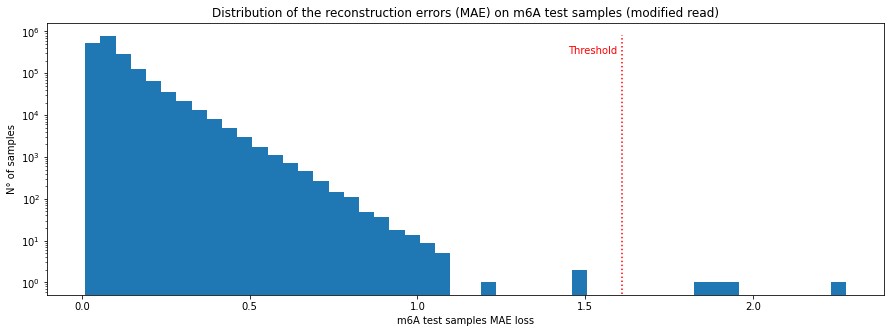

Number of anomaly samples in m6A test reads: 4


In [54]:
plt.figure(figsize=(15,5))
plt.hist(np.concatenate(m6A_test_mae_losses), bins=50)
plt.title("Distribution of the reconstruction errors (MAE) on m6A test samples (modified read)")
plt.vlines(new_threshold, plt.axis()[2], plt.axis()[3], colors="r", linestyles="dotted")
plt.text(new_threshold*0.9, plt.axis()[3]*0.35, "Threshold", c="r")
plt.yscale(value="log")
plt.xlabel("m6A test samples MAE loss")
plt.ylabel("N° of samples")
plt.show()

anomalies_m6A_test = np.concatenate(m6A_test_mae_losses) > new_threshold
print("Number of anomaly samples in m6A test reads:", np.sum(m6A_test_sum_anomalies))

Number of anomalies in m6A_test samples: 4
Percentage of anomalies in m6A_test dataset on total measurements evaluated: 0.00021 %

Number of anomalies in X_test samples: 9
Percentage of anomalies in unmodified X_test dataset on total measurements evaluated: 0.00053 %

m6A_test/X_test anomalies ratio 0.4444444444444444


/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


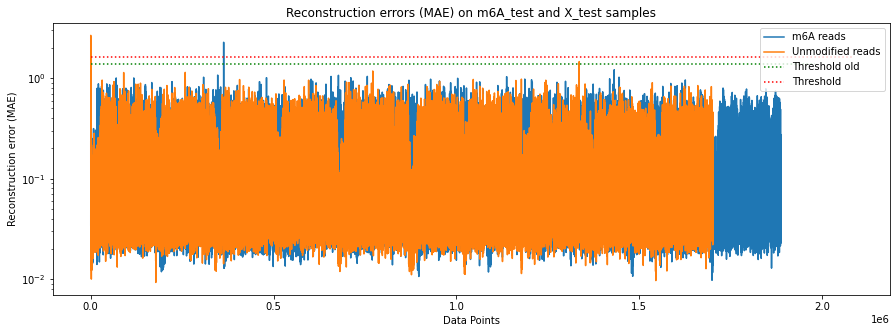

In [55]:
# Results on m6A_test and X_test datasets:
print("Number of anomalies in m6A_test samples:", np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold))
print("Percentage of anomalies in m6A_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / np.concatenate(m6A_test_mae_losses).shape[0] * 100, 5), "%\n" )
print("Number of anomalies in X_test samples:", np.sum(np.concatenate(test_mae_losses) > new_threshold))
print("Percentage of anomalies in unmodified X_test dataset on total measurements evaluated:", round(np.sum(np.concatenate(test_mae_losses) > new_threshold) / np.concatenate(test_mae_losses).shape[0] * 100, 5), "%\n" )
print("m6A_test/X_test anomalies ratio", 
        np.sum(np.concatenate(m6A_test_mae_losses) > new_threshold) / 
        np.sum(np.concatenate(test_mae_losses) > new_threshold))

# Compare the Reconstruction MAE of the model in both the datasets with respect the max_threshold value
# computed in the training dataset.
plt.figure(figsize=(15,5))
plt.title("Reconstruction errors (MAE) on m6A_test and X_test samples")
plt.plot(np.concatenate(m6A_test_mae_losses), label="m6A reads", zorder=0)
plt.plot(np.concatenate(test_mae_losses), label="Unmodified reads", zorder=1)
plt.yscale(value="log")
plt.xlabel("Data Points")
plt.ylabel("Reconstruction error (MAE)")
plt.hlines(threshold_max, -1, plt.axis()[1], colors="g", linestyles="dotted", label="Threshold old", zorder=3)
plt.hlines(new_threshold, -1, plt.axis()[1], colors="r", linestyles="dotted", label="Threshold", zorder=4)
plt.legend()
plt.show()